** A simulation of Thousand Network **
 _by Keld Lundgaard_ 
 ![network_example](figures/network_example.png)


This is a simple simulation of the international network for young high achievers Thousand Network (TN) -- [www.thousandnetwork.com](http://www.thousandnetwork.com).  

TN has as of writing (January 2016) local hubs in about 30 cities and a membership base of around one thousand! I was assigned to make a project that would make people go WOW as part of the entrance test, so I make a simulation of the network itself.   

A simulation is a powerful learning tool, which allows us to put our mental models to the test. We can use it to make quantitative predictions about the future, and ask what would happen in different scenarios. For instance:
 - How will the age distribution change over time depending on a maximum age
 - How does it depend on the recruitment system
 - How connected is the network and what affects the connectivity the most
 
These are some of the questions that I will try to provide answers to.

I will illustrate how the simulation works by increasing its complexity step by step, so that you can get an intuitive feel for it. Afterwards, I will test some future scenarios, and lastly invite you to tweak the model and envision your own future of the network.  

I will mix text and code. You do not need to read or understand the code-blocks to follow the story though. 

Enjoy

In [1]:
from IPython.core.display import HTML, display
# http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import warnings
warnings.filterwarnings("ignore")

%pylab inline
from IPython.display import Image
pylab.rcParams['figure.figsize'] = (8, 6)

# I'll use the igraph library for the graph manipulation 
# through python-igraph api 
import igraph as ig
import os

# These libraries were created for this project, and are shared on GitHub
# https://github.com/keldLundgaard/ThousandNetwork_simulation
from simulation_code import run_simulation, run_simulation_cached
from simulation_data import data
import simulation_stat_plots as ssp

folder = 'Simulation_figures'
if not os.path.exists(folder):
    os.mkdir(folder)

Populating the interactive namespace from numpy and matplotlib


First, let's make a very simple network.  

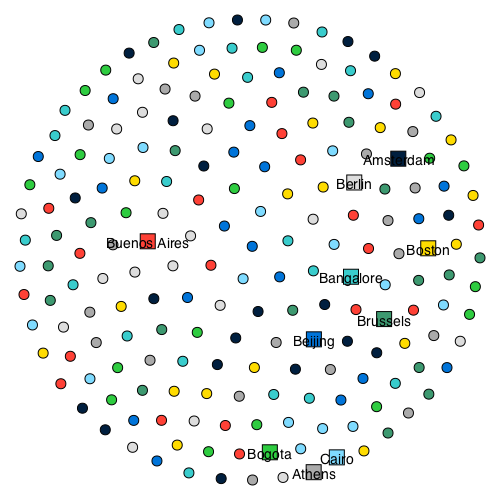

In [4]:
name = 'no_events'
TN_configs = {
    'hub_starting_members_avg': 20,
    'hub_cities': data['ThousandNetwork_cities'][:10]}

g, _ = run_simulation(TN_configs)

ssp.show_graph(g, folder+'/'+name)
Image(folder+'/'+name+'.png')

In the above figure, each shape illustrates a member in the network. We have 10 cities with 20 members each. Every city has a color associated with it -- e.g. blue is for Beijing. The square members are the ambassadors of the cities, and we label the ambassador with the city name. 

Each member has a starting age, which we take from a normal distribution with mean 24 and standard deviation 2. Here is the starting distribution.

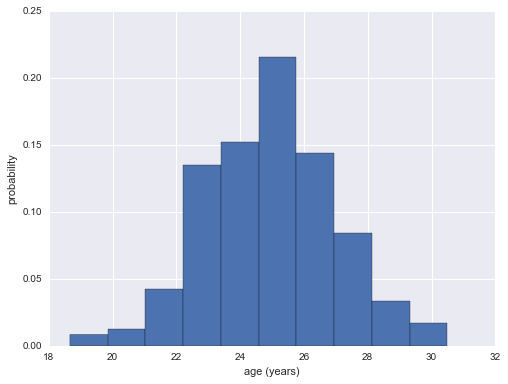

In [5]:
plt.hist(g.vs['age'], normed=True)
plt.xlabel('age (years)')
plt.ylabel('probability')
plt.savefig(folder+'/age_initial.pdf')

Let's make things a bit more interesting by introducing hub events at each city so that people can become connected. In each hub, the ambassador can create a number of yearly events, where some of the hub's members can participate and interact with each other. We'll start with 5 local events with 10 participants each (the ambassador will always be among them). At each event, that the number of interactions between the participants is be 5 times the number of participants, so each participant has 10 interactions on average.

Let's simulate that, where we cluster people who have interacted together.

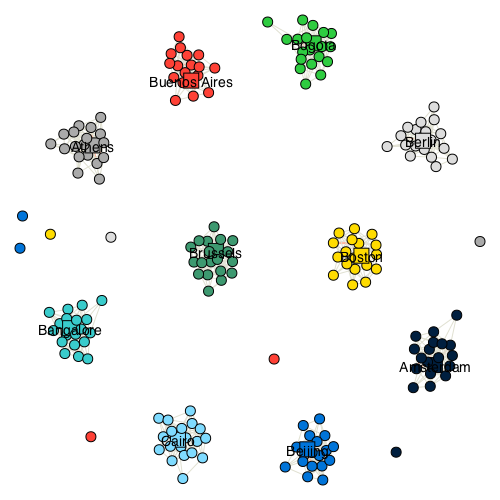

In [6]:
TN_configs.update({
    'yearly_local_events': 5,
    'local_event_participants': 10,
    'local_event_avg_new_link_per_participant': 5,
    'simulation_years': 1})

g, _ = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/local_events')
Image(folder+'/local_events.png')

We now have a cluster for each city, and if you look closely, you can see that there are connections lines between the members. These lines shows who have interacted with each other. 
However, some of the members are all by themselves still. These members haven't participated in any events yet, or perhaps did not make any interactions at the events they participated in. 

Next, let's add an element of time to the simulation. For simplicity, I'll let the simulation operate in years. Every year, we'll have a number of events, like the local events that we saw before. However, we also have to take into account of new member entrance and churn. 

For new members, we'll have each hub take in a number of new members proportional to the current member number. The question is then how fast this growth rate should be. In a startup, the usual organization growth that is strived for is a doubling every year. Back in the early days that might be the growth rate. Now, I would assume that the growth has leveling out a bit, so let's put the growth rate at 25%.

For churn, I'll let the chance that a member leaves depend on how connected he/she is, i.e. less connected members are more likely leave/churn. Let's for simplicity say that it is the number of interactions the person has had over all time that defines the churn rate by 

    chance of leaving = [ 75% / (interations+1) ] + 2%,

where I have added a 2% base rate independent of the number of interactions. 

Let's see how the network will look after we run the simulation for 10 years. First we plot the network after 10 years and then a graph showing the number of members over time. 

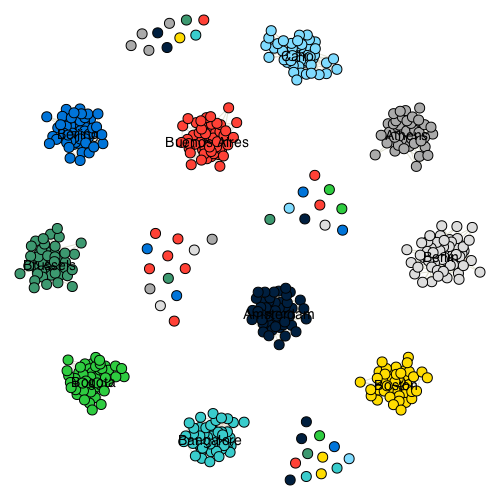

In [7]:
name = 'new_members_and_churn'

TN_configs.update({
    'new_member_ratio': 0.25,
    'base_churn': 0.02,  # base rate
    'churn_no_degree_rate': 0.75,
    'degree_count_power': 1.0,
    'simulation_years': 10})

g, g_states = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/'+name)
Image(folder+'/'+name+'.png')

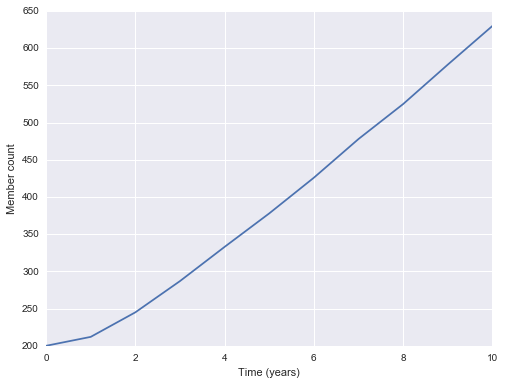

In [8]:
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

We see that the number of members increase steadily from 200 to more than 600 over the 10 years. The growth is linear after a few years. It doesn't seem like the churn is doing much, so let's try to change the way it works.

chance of leaving = [ 75% / square root(interations+1) ] + 2%,

where we now take the square root of the interactions

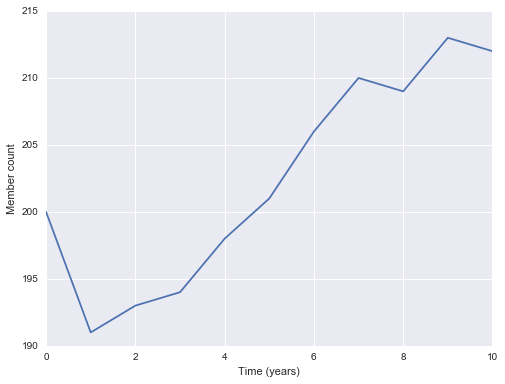

In [9]:
name = 'new_members_and_churn_2'

TN_configs.update({
    'degree_count_power': 0.5,
})
g, g_states = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/'+name)
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

We see a dip it the beginning, and then an increase in members as time goes on. This is because the members start out with no connections, so they'll have a high change of leaving for the first couple of years. Next, we'll add more events to make more connections between our members, so that they won't leave as much. 

**Thousand Network connects internationally **

The different hubs are currently completely isolated. Let's fix that. 

First, members tend to visit other cities, so let's add some city hopping. We'll put a 5% change that a member will move to another city each year. Let's see how network looks after 5 years with such a policy.

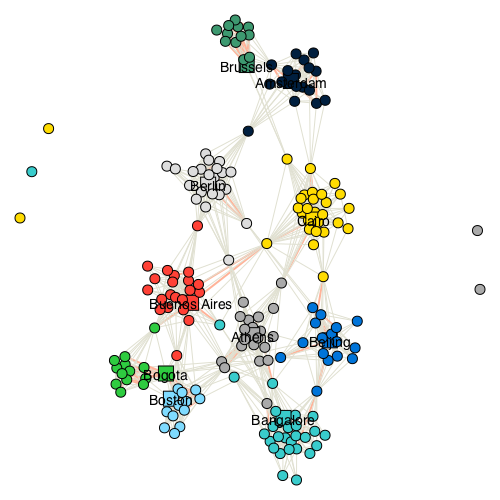

In [10]:
name = 'city_hopping'

TN_configs.update({
    'city_hopping_propability': 0.05, 
    'simulation_years': 5})
g, g_states = run_simulation(TN_configs)
ssp.show_graph(g, folder+'/'+name)
Image(folder+'/'+name+'.png')

The connection lines become orange when two members have interacted more than 5 times. 

We see that a number of members change city, but still have a lot of connections to their former city members, so it looks like they are in between the two city social groups. 

Members also meet at the global retreats also, so let's add such. 

With 10 cities, I will let the global event have 100 participants and create an average of 40 interactions per participant during the event! We'll give preference to the ambassadors of the cities, and fill out the rest of the slots with members of the hubs randomly. 

NB: I will now delete members with no connections at the end of the simulation for the visualizations.

Let's see how that changes things.

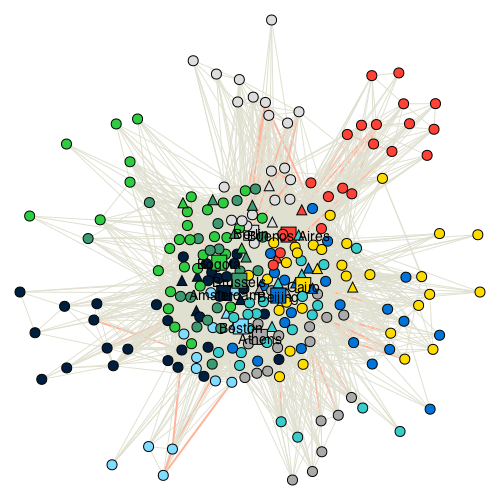

In [12]:
name = 'with_global_event'

TN_configs.update({
    'yearly_global_retreats': 1,
    'global_retreat_goers': 100,
    'global_retreat_link_multiplier': 20,
    })
g, g_states = run_simulation(TN_configs)
ssp.plot_graph(
    g, folder+'/'+name+'.png', 
    delete_zero_connections=1)
Image(folder+'/'+name+'.png')

Now we have a truly globally connected network! The social networks in the cities are now almost merged together. 

** Electing new ambassadors **

Currently, the ambassadors are fixed for the entire duration of the simulation. Let's instead make it so that each hub will elect a new year ambassador each year. To choose the next ambassador, I'll use the square root to the number of connections for each member to determine who will be elected as the next ambassador, so that the more connections the higher chance that you will become the next ambassador. It is possible to be reelected.

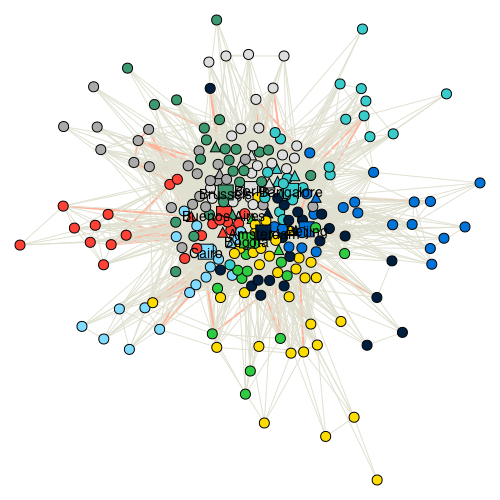

In [13]:
name = 'with_new_ambassador_election'

TN_configs.update({
    'promote_new_ambassador_yearly': True,
})
g, g_states = run_simulation(TN_configs)
ssp.plot_graph(
    g, folder+'/'+name+'.png', 
    delete_zero_connections=1)
Image(folder+'/'+name+'.png')

A triangle indicate that the member has been an ambassador in the past, while current ambassadors are still squares. We can see that the ambassadors tend to be clustered in the middle as they are the mostly connected members.

Let's compare connection distributions of the normal members and current/past ambassadors. 

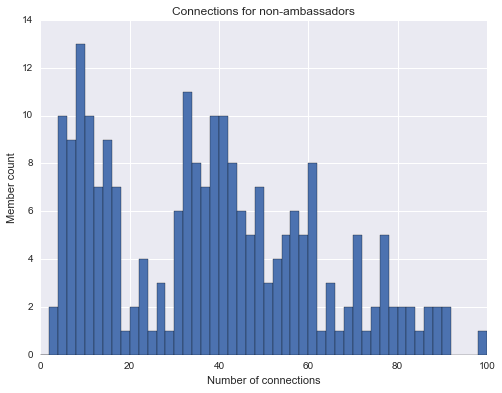

In [24]:
name = 'non_ambassador_degrees'
ssp.plot_members_degree(
    g,
    folder+'/'+name+'.png',
    limit='non_ambassadors',
    title='Connections for non-ambassadors')

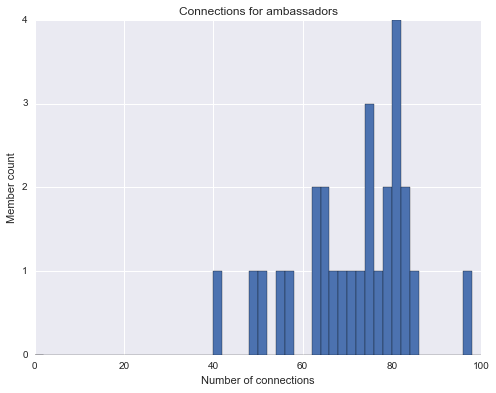

In [25]:
name = 'ambassadors_all_times'

ssp.plot_members_degree(
    g,
    folder+'/'+name+'.png',
    limit='ambassadors_all_times',
    title='Connections for ambassadors')

It is apparent that ambassadors tent to have more connections, but we can also see that some of the non-ambassadors have just as many connections as the ambassadors.

** Long term trends**

Let's see how the number of members change a longer stretch of time, say 20 years. Since the 10 year simulation, we have introduced a number of ways that members can interact, which should have reduced the churn. 

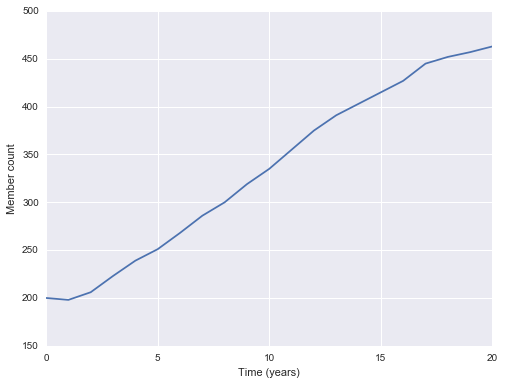

In [26]:
name = 'members_over_time'

TN_configs.update({
    'simulation_years': 20
})
g, g_states = run_simulation(TN_configs)
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

Yep, that made a big difference. The network only looses a few members in the beginning, and then steadily increase its member count. 


** Maximum age of members **

What happens happens to the age distribution as time goes on?

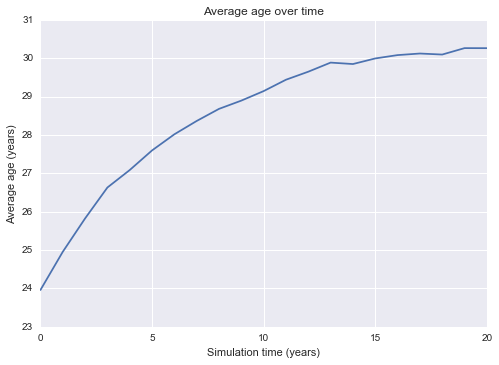

In [15]:
name = 'avg_age_over_time'
ssp.plot_avg_age_over_time(
        g_states,
        filename=folder+'/.pdf')

We see that the average age steadily increases to around 30 years old. What happens if we start kicking members out when they turn say 35 year old.

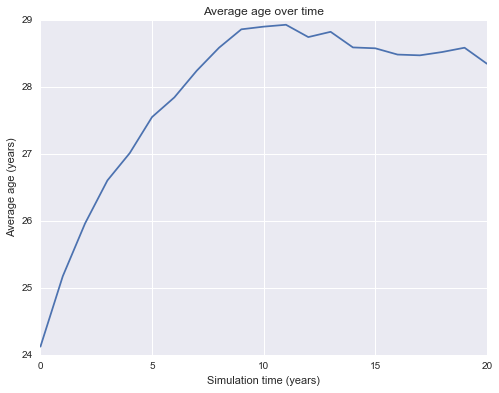

In [27]:
name = 'avg_age_over_time_max_35'

TN_configs.update({
    'max_age': 35,
})
g, g_states = run_simulation(TN_configs)

ssp.plot_avg_age_over_time(
        g_states,
        filename=folder+'/.pdf')

This has the effect of flattening out the member count after about 10 years. So after 10 years the number of new members is about equal to the number of members who leave the network. 

We can also see how the age distribution changes over time.

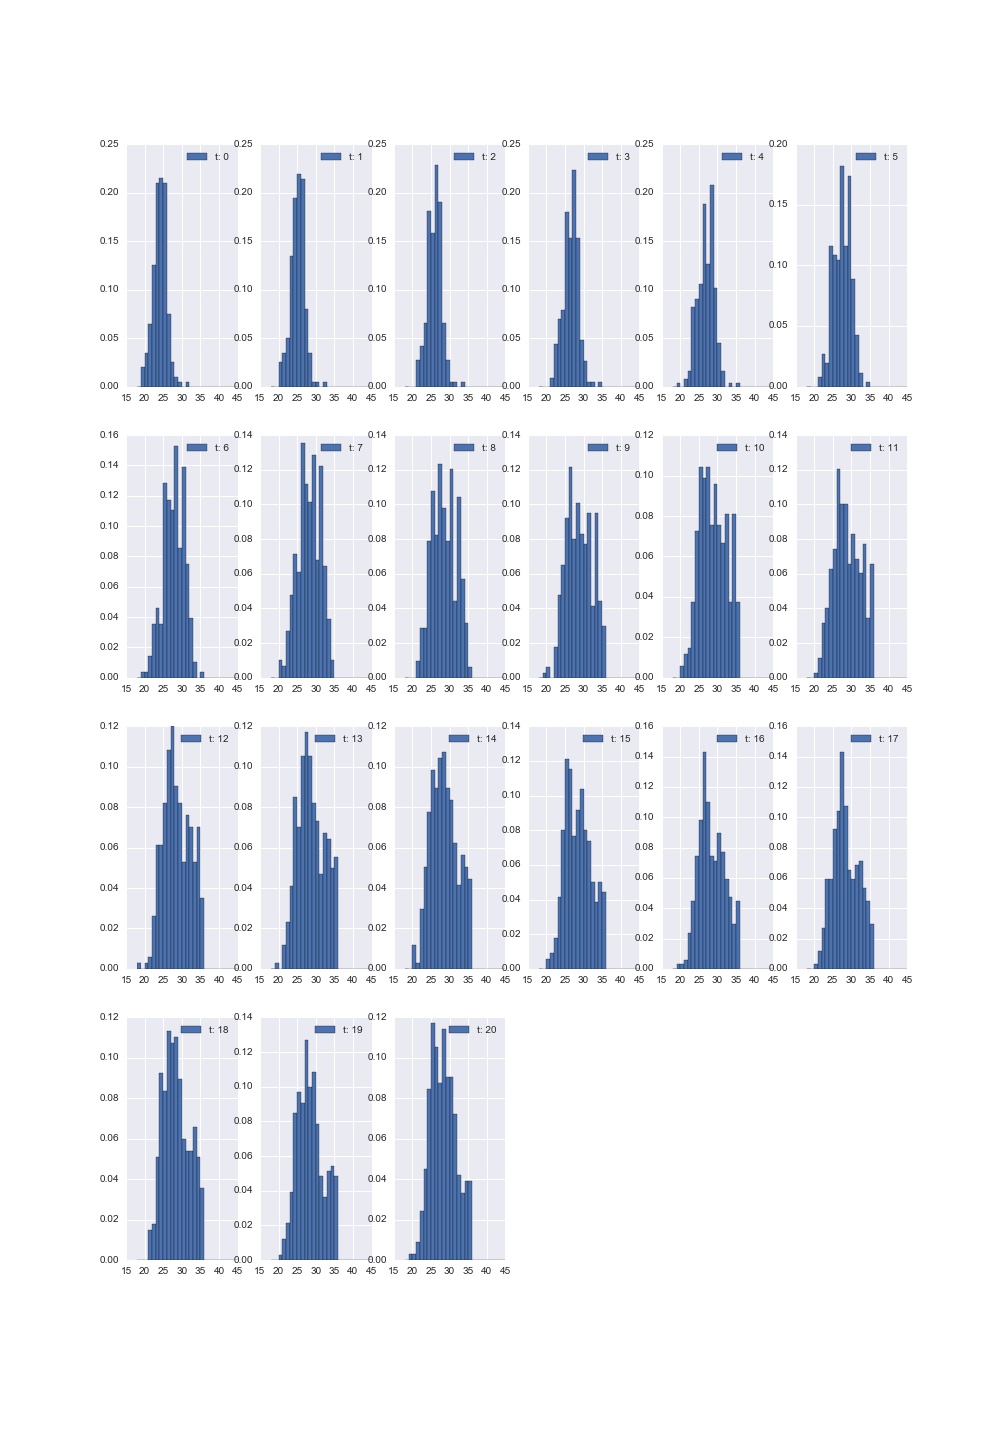

In [28]:
name = 'Age_distribution_over_time'
ssp.plot_age_distribution_over_time(g_states, filename=folder+'/'+name+'.png')
Image(filename=folder+'/'+name+'.png')

We see a sharp decline at 35 years as expected, and that shape of the distribution remains pretty constant, but with a shift to the right. 

Let's try to compare the member count depending on the members uptake rate. What happens if we increase it from 25% to 50%?

In [29]:
name = 'higher _time_max_35'

TN_configs.update({
    'new_member_ratio': 0.5,                  
})
g_1, g_states_1 = run_simulation(TN_configs)

TN_configs.update({
    'new_member_ratio': 0.25,                  
})

g, g_states = run_simulation(TN_configs)


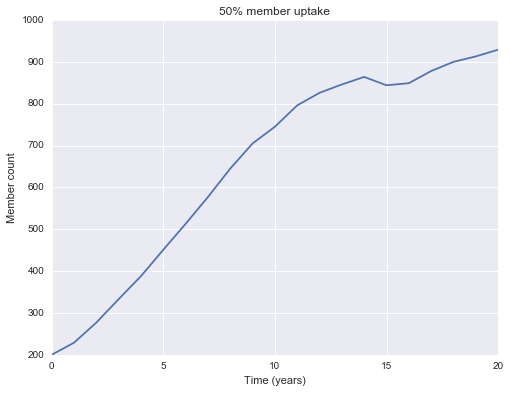

In [31]:
ssp.plot_members_over_time(
    g_states_1, 
    filename=folder+'/member_count_50_percent_uptake.pdf',
    title='50% member uptake',)

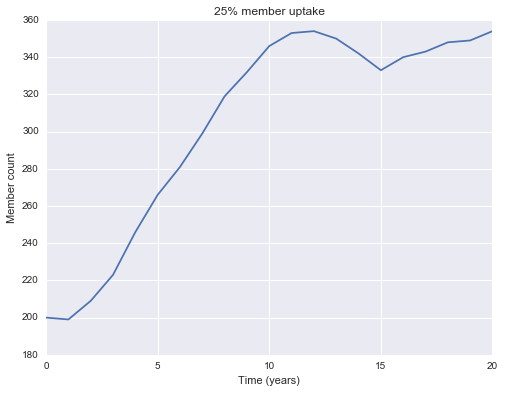

In [32]:
ssp.plot_members_over_time(
    g_states, 
    filename=folder+'/member_count_25_percent_uptake.pdf',
    title='25% member uptake')

Not surprisingly, we get a much higher member count when increase the member uptake to 50%. The member count still levels out at some point though, but now at around 1000 members for the 10 cities. Let's see how number of connections each member has changes as we increase the member uptake. Remember that the number of events and number of participants are fixed.  

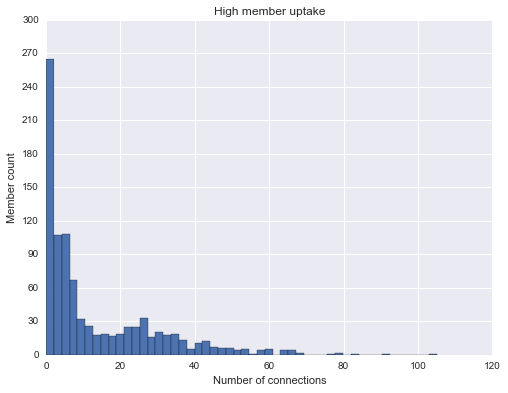

In [35]:
ssp.plot_members_degree(
    g_1, folder+'/all_member_degrees_high_uptake.png', 
    title='High member uptake');

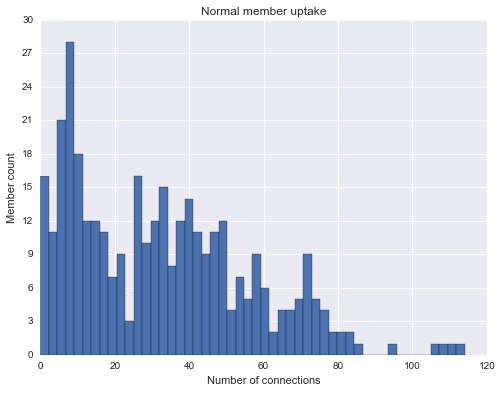

In [36]:
ssp.plot_members_degree(
    g, folder+'/all_member_degrees_normal_uptake.png', 
    title='Normal member uptake');

We see that members have way fewer connections. We could, however, imagine that the ambassadors would start to make more/bigger local events they had more hub members.

** Connectivity ** 

The last question that I want explore here is how connected the network is. This could be measured by how many steps you usually have to go through to reach another member. I'll here ignore the members who without any connections. This is similar to the small world problem (http://snap.stanford.edu/class/cs224w-readings/milgram67smallworld.pdf).

Let's see how it looks for the network.

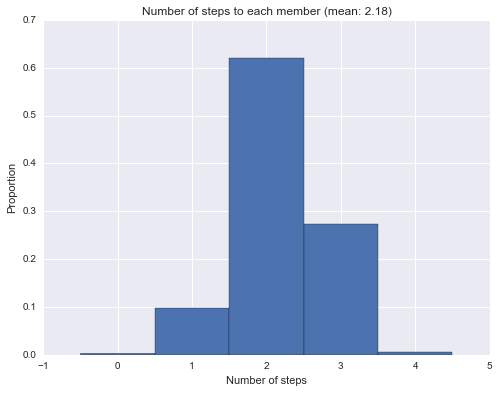

In [38]:
name = 'connection_distance_between_members'
ssp.hist_shortest_path(g, folder+'/'+name+'.png')

On average there is about 2 connections between the members, but with some member pairs who need to go though 4 people. This would probably depend on how many years they have been in the network. The older will have more connections, while new very few. 

** Full network **

Let's now try to put everything together and make a simulation with all the cities. I have made a couple of adjustments here: Initializing all the current hub cities, increasing city hopping to 10%, 6 local events with 15 participants, one global event with 300 participants, 10% change of city hopping, member uptake ratio 25%.

In [39]:
name = 'Full Thousand network simulation'

TN_configs_full ={
    'verbose': 1,
    
    # Initializing 
    'hub_cities': data['ThousandNetwork_cities'],
    'hub_starting_members_avg': 25,
    'mean_starting_age': 24,
    'starting_age_std': 2,
    
    # Local events
    'yearly_local_events': 6,
    'local_event_participants': 15,
    'local_event_avg_new_link_per_participant': 5,

    # Global retreat        
    'yearly_global_retreats': 1,
    'global_retreat_goers': 300,
    'global_retreat_link_multiplier': 20,

    # city hopping
    'city_hopping_propability': 0.10,  # 10% chance of changing city    
        
    # New members
    'new_member_ratio': 0.25,                  
    
    # Change ambassadors    
    'promote_new_ambassador_yearly': True,
    
    # churn
    'churn_no_degree_rate': 0.8,
    'base_churn': 0.02, 
    'max_age': 35,
    
    # overall
    'degree_count_power': 0.5, 
    'simulation_years': 20,
    }
g_states = run_simulation_cached(
        TN_configs_full,
        'full_thousand_network',
        redo=False,
        simu_folder='')

g_full = g_states[-1]

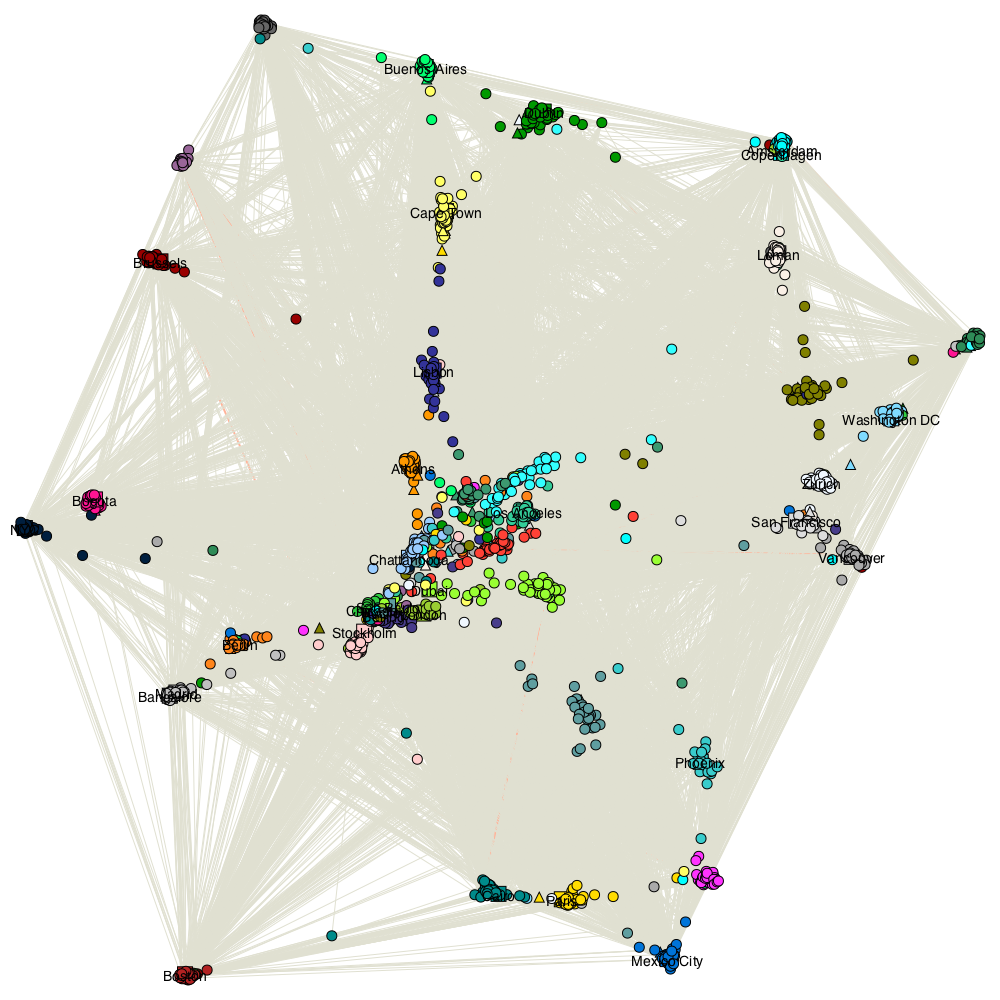

In [30]:
fig_name = "full_network_graph"
ssp.plot_graph(
    g_full, folder+'/'+fig_name+'.png', 
#     layout=g_full.layout_fruchterman_reingold(),
    visual_styling={'bbox': (0, 0, 1000, 1000)},
    delete_zero_connections=1)
Image(folder+'/'+fig_name+".png");

Interesting. It is hard to follow connections as there are so many that crosses each other. However, we can see many of the same things as before, just on a bigger scale here: City groups, members who are in between the social networks of different cities, city networks that almost coincide, and more. 

The change in the number of members can be seen here.

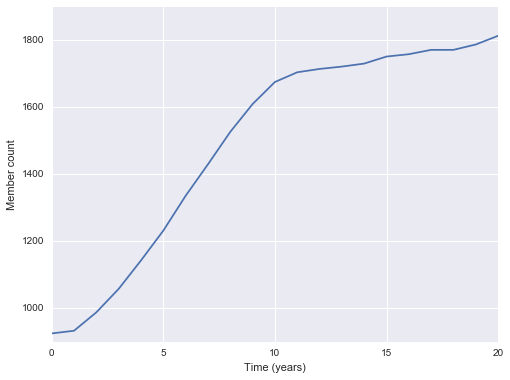

In [40]:
name = 'full_simulation_members'
ssp.plot_members_over_time(g_states, filename=folder+'/'+name+'.pdf')

The number of members goes up to a couple of thousand members and then levels off, with a very wide distribute on the number of connections as can be seen below.

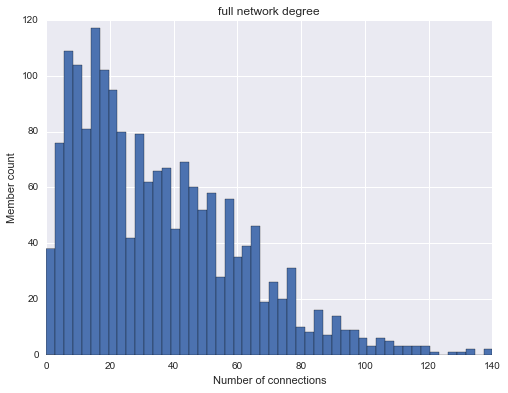

In [43]:
ssp.plot_members_degree(g_full, folder+'/ambassador_degrees_full.png', title='full network degree')

And for the connectivity:

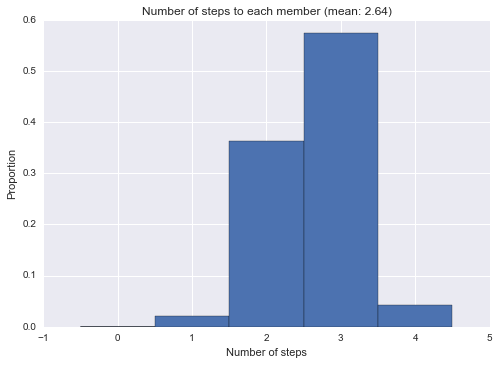

In [28]:
name = 'connection_distance_between_members_full'
ssp.hist_shortest_path(g_full, folder+'/'+name+'.png')

We can see that the average number of connections between the members has gone up by about half a connection. 

** End notes**

What did we learn? What might have been surprising? 

 - That the age of a network will keep increasing if there not a policy like a maximum age.
 - That both city hopping and global events are important for making a truly international network.
 - That it is likely that all members can reach each other following less than 3 connections.

There are so many more things could be done here to make the simulation more realistic and interesting. For example.

 - Starting new city hubs. All hubs are set from the beginning, which is not realistic. Closing hubs should also be an option - say if there are fewer than x members. It would be quite interesting if the simulation could reproduce the evolution of the real network from it's beginning in 2009.
 - More ways members can interact depending on connection strengths. In social network analysis the members with strong bonds tend to introduce each other to their friends which makes the network more closely connected (This is called a triage). 
 - Interactive simulation with animation. It would be interesting to interact with the network as the simulation unfolds, and to have the ability to easily look at a part of the network. 
 - Interaction with the outside world. The number of members within each city hub could be dependent on popularity of the cities, GDP, or other things. The simulation could use future projections from e.g. think tanks as inputs.


If you feel inclined to take upon you some of these questions then feel free to fork the simulation code which is [avaliable on github](https://github.com/keldLundgaard/ThousandNetwork_simulation). 


Keld 

========

PS:

Please add an issue on [github](https://github.com/keldLundgaard/ThousandNetwork_simulation) if you have any ideas for improvements, corrections, or want to give some feedback. Also feel free to write to me directly at keld.lundgaard[at]gmail.com.